# Self-Organizing Maps

Self-Organizing Systems TU Wien (2020/21)

In this notebook, we present visualization techniques for self-organizing maps based on graph projection techniques as presented in [Pölzlbauer et al. (Graph projection techniques
for Self-Organizing Maps)](https://www.google.at/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwisj76ykcbuAhXCu6QKHaCIAQgQFjABegQIARAC&url=http%3A%2F%2Fwww.ifs.tuwien.ac.at%2F~poelzlbauer%2Fpublications%2FPoe05ESANN.pdf&usg=AOvVaw2AOBbphdk1VARIBg-Rv8p2)

Both approaches introduces in the paper, based on knn and the spherical neighborhood limited by some given radius within the input space were implemented and are illustrated on two standard benchmark instances (chain link and 10-clusters, which can be obtained from [here](http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets.html)).


## 1. Imports and Dependencies

Our implementation is primarily based on scipy, where computation is based on vectorized computing with numpy.

Although visualization of the template of this notebook was based on plotly, we experienced performance issues in the interactive mode in large instances due to vast number of lines plotted. To this end, we fell back to static plots created with seaborn.


In [36]:
import gzip
from typing import List

import matplotlib.pyplot as plt
import minisom as som
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sbs
import sklearn.metrics
from matplotlib.collections import LineCollection
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import distance_matrix
from sklearn import datasets, preprocessing
from sklearn.neighbors import KDTree
#
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))


## 2. Parsing

This section was taken from the template and is responsible for parsing of input and weight files. A detailed description of input file formats of [SOMToolbox](http://www.ifs.tuwien.ac.at/dm/somtoolbox/somlibFileFormat.html) can be found [here](http://www.ifs.tuwien.ac.at/dm/somtoolbox/somlibFileFormat.html)

In [37]:
class SOMToolBox_Parse:
    
    def __init__(self, filename):
        self.filename = filename
    
    def read_weight_file(self,):
        df = pd.DataFrame()
        if self.filename[-3:len(self.filename)] == '.gz':
            with gzip.open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)
        else:
            with open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)

        file.close()            
        return df.astype('float64'), vec_dim, xdim, ydim


    def _read_vector_file_to_df(self, df, file):
        xdim, ydim, vec_dim, position = 0, 0, 0, 0
        for byte in file:
            line = byte.decode('UTF-8')
            if line.startswith('$'):
                xdim, ydim, vec_dim = self._parse_vector_file_metadata(line, xdim, ydim, vec_dim)
                if xdim > 0 and ydim > 0 and len(df.columns) == 0:
                    df = pd.DataFrame(index=range(0, ydim * xdim), columns=range(0, vec_dim))
            else:
                if len(df.columns) == 0 or vec_dim == 0:
                    raise ValueError('Weight file has no correct Dimensional information.')
                position = self._parse_weight_file_data(line, position, vec_dim, df)
        return df, vec_dim, xdim, ydim


    def _parse_weight_file_data(self, line, position, vec_dim, df):
        splitted=line.split(' ')
        try:
            df.values[position] = list(np.array(splitted[0:vec_dim]).astype(float))
            position += 1
        except: raise ValueError('The input-vector file does not match its unit-dimension.') 
        return  position


    def _parse_vector_file_metadata(self, line, xdim, ydim, vec_dim):
        splitted = line.split(' ')
        if splitted[0] == '$XDIM':      xdim = int(splitted[1])
        elif splitted[0] == '$YDIM':    ydim = int(splitted[1])
        elif splitted[0] == '$VEC_DIM': vec_dim = int(splitted[1])
        return xdim, ydim, vec_dim 
        

## 3. Visualization

The following class implements different SOM visualization approaches, based on density (hithist, sdh and neighborhood graphs) as well as distances (u-matrix).

Our contribution in this notebook are both implementations of the neighborhood graph approaches, which create visual overlays over the u-matrix plot.

In general, these graph projection visualizations are based on neighborhood graphs in the input space, and project them onto the respective units in the output graph.
While both approaches consider each vector in the input space, they differ in the construction of their neighbourhood.
While the knn approach considers for each input vector its k nearest neighbours, regardless of their distance, the radius method considers any neighbour in the input space within a given radius from a vector.
Based on the vertices and their neighbourhoods, the respective edges are then projected to the output space.
Edges, whose incident vertices are projected to the same output unit are omitted as they indicate proper topology preservation.
On the other hand, however, edges between different output units serve as the actual output of this visualization and may serve as an indicator for topology violations, as close neighbours in the input space are mapped to (potentially) distant units in the output space.
As this leads (depending on the configuration) to a vast number of edges in the output space, we slightly improved the visualization, by highlighting the longest n (=10) edges in the output space, serving as an indicator for the sparsest regions for the given configuration.

In [38]:

class SomViz:
    
    def __init__(self, weights=[], m=None, n=None):
        self.weights = weights
        self.m = m
        self.n = n

    def umatrix(self, som_map=None, color="Viridis", interp = "best", title=""):
        # provided by the template
        um =np.zeros((self.m *self.n, 1))
        neuron_locs = list()
        for i in range(self.m):
            for j in range(self.n):
                neuron_locs.append(np.array([i, j]))
        neuron_distmat = distance_matrix(neuron_locs,neuron_locs)

        for i in range(self.m * self.n):
            neighbor_idxs = neuron_distmat[i] <= 1
            neighbor_weights = self.weights[neighbor_idxs]
            um[i] = distance_matrix(np.expand_dims(self.weights[i], 0), neighbor_weights).mean()

        if som_map==None: return self.plot(um.reshape(self.m,self.n), color=color, interp=interp, title=title)    
        else: som_map.data[0].z = um.reshape(self.m,self.n)

    def hithist(self, som_map=None, idata = [], color='RdBu', interp = "best", title=""):
        # provided by the template
        hist = [0] *self.n *self.m
        for v in idata: 
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            hist[position] += 1    
        
        if som_map==None: return self.plot(np.array(hist).reshape(self.m,self.n), color=color, interp=interp, title=title)        
        else:  som_map.data[0].z = np.array(hist).reshape(self.m,self.n)

    def component_plane(self, som_map=None, component=0, color="Viridis", interp = "best", title=""):
        # provided by the template
        if som_map==None: return self.plot(self.weights[:,component].reshape(-1,self.n), color=color, interp=interp, title=title)   
        else:  som_map.data[0].z = self.weights[:,component].reshape(-1,n)

    def sdh(self, som_map=None, idata=[], sdh_type=1, factor=1, draw=True, color="Cividis", interp = "best", title=""):
        # provided by the template
        import heapq
        sdh_m = [0] *self.m *self.n

        cs=0
        for i in range(0,factor): cs += factor-i

        for vector in idata:
            dist = np.sqrt(np.sum(np.power(self.weights - vector, 2), axis=1))
            c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
            if (sdh_type==1): 
                for j in range(0,factor):  sdh_m[c[j]] += (factor-j)/cs # normalized
            if (sdh_type==2):
                for j in range(0,factor): sdh_m[c[j]] += 1.0/dist[c[j]] # based on distance
            if (sdh_type==3): 
                dmin = min(dist)
                for j in range(0,factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(max(dist)-dmin)  

        if som_map==None: return self.plot(np.array(sdh_m).reshape(-1,self.n), color=color, interp=interp, title=title)      
        else: som_map.data[0].z = np.array(sdh_m).reshape(-1,self.n)
        
    def project_data(self,som_m=None, idata=[], title=""):
        # provided by the template
        data_y = []
        data_x = []
        for v in idata:
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            x,y = position % self.n, position // self.n
            data_x.extend([x])
            data_y.extend([y])
            
        if som_m!=None: som_m.add_trace(go.Scatter(x=data_x, y=data_y, mode = "markers", marker_color='rgba(255, 255, 255, 0.8)',))
    
    def time_series(self, som_m=None, idata=[], wsize=50, title=""): #not tested
        # provided by the template, not used, thus not ported to support the new seaborn based visualization
        data_y = []
        data_x = [i for i in range(0,len(idata))]
        
        data_x2 = []
        data_y2 = []
        
        qmin = np.Inf
        qmax = 0
        
        step=1
        
        ps = []
        for v in idata:
            matrix = np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1))
            position = np.argmin(matrix)
            qerror = matrix[position]
            if qmin>qerror: qmin = qerror
            if qmax<qerror: qmax = qerror
            ps.append((position, qerror))
       
        markerc=[]    
        for v in ps:
            data_y.extend([v[0]])
            rez = v[1]/qmax
 
            markerc.append('rgba(0, 0, 0, '+str(rez)+')') 
            
            x,y = v[0] % self.n, v[0] // self.n 
            if    x==0: y = np.random.uniform(low=y, high=y+.1)
            elif  x==self.m-1: y = np.random.uniform(low=y-.1, high=y)
            elif  y==0: x = np.random.uniform(low=x, high=x+.1)
            elif  y==self.n-1: x = np.random.uniform(low=x-.1, high=x)
            else: x,y = np.random.uniform(low=x-.1, high=x+.1), np.random.uniform(low=y-.1, high=y+.1)                           
            
            data_x2.extend([x])
            data_y2.extend([y]) 
    
        # ts_plot = go.FigureWidget(go.Scatter(x=[], y=[], mode = "markers", marker_color=markerc, marker=dict(colorscale='Viridis', showscale=True, color=np.random.randn(500))))
        # ts_plot.update_xaxes(range=[0, wsize])
        #
        #
        # ts_plot.data[0].x, ts_plot.data[0].y = data_x, data_y
        # som_m.add_trace(go.Scatter(x=data_x2, y=data_y2, mode = "markers",))
        #
        # som_m.layout.height = 500
        # ts_plot.layout.height = 500
        # som_m.layout.width = 500
        # ts_plot.layout.width = 1300
        
        # return HBox([go.FigureWidget(som_m), go.FigureWidget(ts_plot)])

    def plot(self, matrix, color="Viridis", interp = "best", title=""):
        # creates a heatmap plot with seaborn, and optional performs some smoothing with a gaussian filter

        fig, ax1 = plt.subplots(figsize=(15, 10))

        if interp is not False: # an easy substitute...
            matrix = gaussian_filter(matrix, sigma=0.5)

        sbs.heatmap(data=matrix, ax=ax1, cmap=color, cbar=False)

        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_ticks([])
        frame1.axes.get_yaxis().set_ticks([])

        return fig
        # return go.FigureWidget(go.Heatmap(z=matrix, zsmooth=interp, showscale=False, colorscale=color), layout=go.Layout(width=1400, height=700,title=title, title_x=0.5,))

    # helper function for getting corrected (x,y) indices for weight array indexes
    def get_reshapesindex(self, position):
        return position % self.n, position // self.n

    def prepare_um_figure(self, color="Viridis", interp=False, title=""):
        # First compute U-matrix values
        um = np.zeros((self.m * self.n, 1))
        neuron_locs = list()
        for i in range(self.m):
            for j in range(self.n):
                neuron_locs.append(np.array([i, j]))
        neuron_distmat = distance_matrix(neuron_locs, neuron_locs)

        for i in range(self.m * self.n):
            neighbor_idxs = neuron_distmat[i] <= 1
            neighbor_weights = self.weights[neighbor_idxs]
            um[i] = distance_matrix(np.expand_dims(self.weights[i], 0),
                                    neighbor_weights).mean()

        return self.plot(um.reshape(self.m, self.n), color=color, interp=interp, title=title)


    def plot_lines(self, figure, lines: List, highlight_longest_n:int ):
        longest_lines = []
        if highlight_longest_n is not None:
            line_lengths = [(((x1, y1), (x2, y2)), np.linalg.norm(
                np.array((x1, y1) - np.array((x2, y2))))) for (x1, y1), (x2, y2)
                            in lines]
            longest_lines = [x[0] for x in
                             sorted(line_lengths, key=lambda x: x[1],
                                    reverse=True)[0:highlight_longest_n]]

        if highlight_longest_n is None:
            lc = LineCollection([l for l in lines], color="red", lw=2)
            plt.gca().add_collection(lc)
        else:
            lc = LineCollection([l for l in lines if l not in longest_lines],color="red", lw=2)
            lc2 = LineCollection([l for l in lines if l in longest_lines],color="black", lw=3)
            plt.gca().add_collection(lc)
            plt.gca().add_collection(lc2)
        return figure


    def neighbourhood_knn(self, idata, k = 1, color="Viridis", interp = False, title="", highlight_longest_n:int = None):

        figure = self.prepare_um_figure(color, interp, title)

        # Start k-NN computation
        idata = idata.to_numpy()
        # build kd-tree on input vectors
        tree = KDTree(idata) # euclidean metric is already used here
        # use cache for best matching unit computation
        positionchache = {}

        lines = []
        # for each input vector do knn computation
        for ind_orig, v in enumerate(idata): 
            if tuple(v) in positionchache:
                position1 = positionchache[tuple(v)]
            else:
                position1 = np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))

            nearest_dist, nearest_ind = tree.query([v], k=(k+1))  # k+1 because we also get the query point
            inds = nearest_ind[0][:]
            for ind in inds:
                if ind != ind_orig:
                    position2 = np.argmin(np.sqrt(np.sum(np.power(self.weights - idata[ind], 2), axis=1)))
                    if tuple(idata[ind]) in positionchache:
                        position2 = positionchache[tuple(idata[ind])]
                    else:
                        position2 = np.argmin(np.sqrt(np.sum(np.power(self.weights - idata[ind], 2), axis=1)))

                    if position1 != position2:
                        # different units, draw line
                        x1,y1 = self.get_reshapesindex(position1)
                        x2,y2 = self.get_reshapesindex(position2)
                        lines.append(((x1,y1),(x2,y2)))

        return self.plot_lines(figure, lines, highlight_longest_n)




    def neighbourhood_radius(self, idata, radius=0.2, color="Viridis",
                             interp=False,
                             title="", highlight_longest_n:int = None):

        # prepare the u-map background
        figure = self.prepare_um_figure(color, interp, title)

        num_nodes = idata.shape[0]
        feature_dim = idata.shape[1]
        input = idata.to_numpy()


        # for each input vector, get the assigned output unit (index), based on euclidean distance
        input_assigned_units = np.apply_along_axis(lambda x: np.argmin(
            np.linalg.norm(self.weights - x.reshape((1, feature_dim)), axis=1)),
                                                   1, input)

        # obtained the coords of the output units, based on their index derive above
        assigned_unit_coords = np.apply_along_axis(
            lambda x: self.get_reshapesindex(x),
            axis=0, arr=input_assigned_units)

        assignment_x = assigned_unit_coords[0]
        assignment_y = assigned_unit_coords[1]


        # compute pairwise euclidean distance between inputs, required for selecting the neighborhood
        distances = sklearn.metrics.pairwise_distances(input)

        # filter distance matrix by radius --> yields boolean matrix
        filtered_by_radius = distances < radius

        # remove loops in the arc (with distance = 0)
        np.fill_diagonal(filtered_by_radius, False)

        # remove upper diagonal of this matrix, as the edges are undirected
        filtered_by_radius_without_upper_triangle = np.tril(filtered_by_radius).astype(np.int)

        # we multiply an index matrix (0...n) with the boolean one, to obtain in each column vector a list of relevant unit indices
        index_matrix = np.array(
            [list(range(0, num_nodes)), ] * num_nodes).transpose()
        filtered_unit_index_matrix = np.multiply(filtered_by_radius_without_upper_triangle, index_matrix)

        # set irrelevant columns to -1
        result_matrix = np.where(filtered_unit_index_matrix > 0, filtered_unit_index_matrix, -1)


        # visualization: iterate through column vectors, obtain unit coordindates and insert into line set
        lines = set()

        for i in range(0, num_nodes):
            my_coords = (assignment_x[i], assignment_y[i])

            my_partners_filtered = np.where(result_matrix[:, i] > -1)

            if len(my_partners_filtered[0]) == 0:
                continue

            partner_x_coords = np.vectorize(lambda x: assignment_x[x])(
                my_partners_filtered)
            partner_y_coords = np.vectorize(lambda y: assignment_y[y])(
                my_partners_filtered)

            coords = np.concatenate([partner_x_coords, partner_y_coords],
                                    axis=0).transpose()

            array_of_tuples = list(map(list, coords))

            neighbors = {tuple(val) for val in array_of_tuples}

            neighbors = {t for t in neighbors if t != my_coords}

            for n in neighbors:
                lines.add((my_coords, n))

        # plot lines
        return self.plot_lines(figure, lines, highlight_longest_n)


## 4. Experiments

In the following we will evaluate different parameter settings of our neighbourhood graph visualization implementations and compare them to other visualizations.
As benchmarking instances, we used chain-link and 10-clusters with 40x20 and 100x60 SOM output units.


### 4.1 Chain Link

![Chain Link illustration from somtoolbox](http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets/chainlink/chainlink-info.png "Source: http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets/chainlink/chainlink-info.png")

Characteristics:
- 3 dimensional input space
- 1000 input vectors
- dataset "provoking topology violations" [[source](http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets.html)] in two dimensional space

#### 4.1.1 Small instance (40x20)

<ipython-input-39-3f05435fd77c>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-39-3f05435fd77c>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


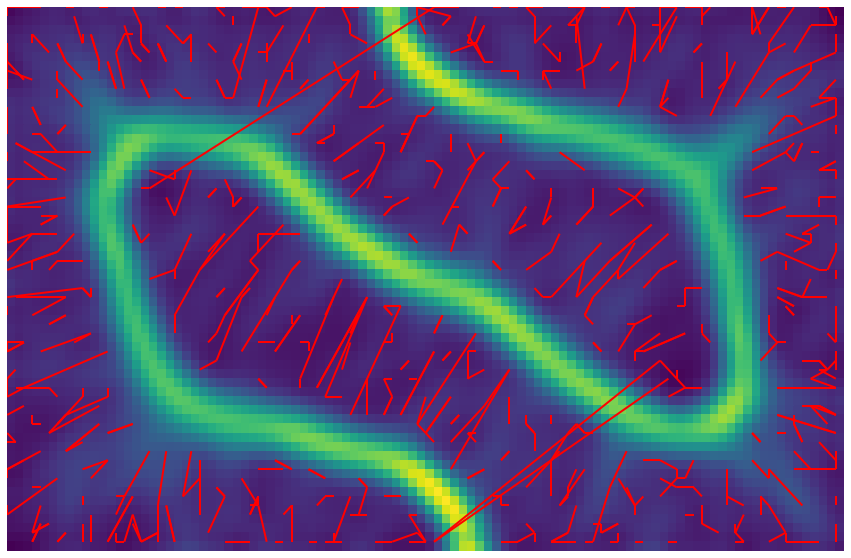

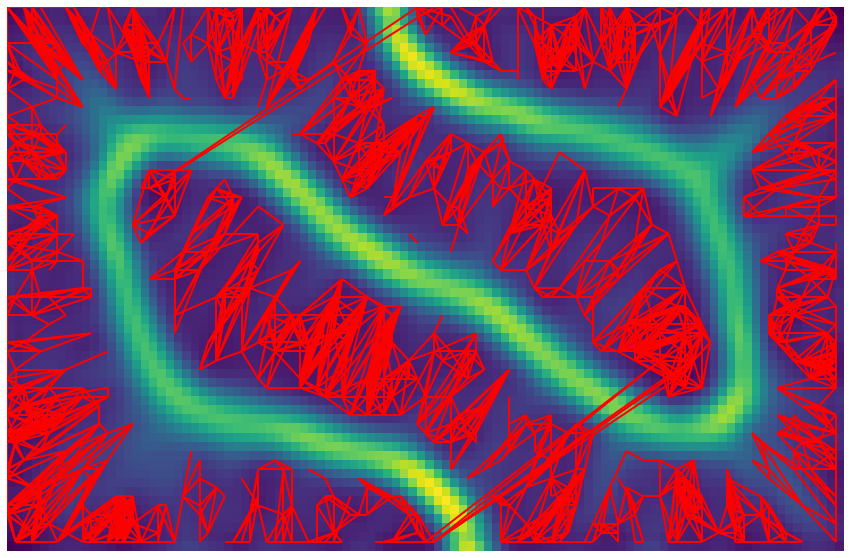

In [39]:
# read from SOM toolbox
trainedmap = SOMToolBox_Parse('data/chainlink_input.vec')
idata, idim, idata_x, idata_y = trainedmap.read_weight_file()

smap = SOMToolBox_Parse('data/chainlink_40x20.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
fig = viz_SOMToolBox.neighbourhood_knn(k = 1, idata = idata, color='viridis', interp=False, title='U-matrix SOMToolBox')
fig.show()
fig = viz_SOMToolBox.neighbourhood_radius(radius=0.1, idata = idata, color='viridis', interp=False, title='U-matrix SOMToolBox 222')
fig.show()






#### 4.1.2. Large instance (100x60)

In [ ]:
# read from SOM toolbox
trainedmap = SOMToolBox_Parse('data/chainlink_input.vec')
idata, idim, idata_x, idata_y = trainedmap.read_weight_file()

smap = SOMToolBox_Parse('data/chainlink_100x60.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
fig = viz_SOMToolBox.neighbourhood_knn(k = 1, idata = idata, color='viridis', interp=False, title='U-matrix SOMToolBox')
fig.show()
fig = viz_SOMToolBox.neighbourhood_radius(radius=0.1, idata = idata, color='viridis', interp=False, title='U-matrix SOMToolBox 222')
fig.show()



### 4.2 10 Clusters

![10 Clusters illustration from somtoolbox](http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets/10clusters/10clusters-info.png "Source: http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets/10clusters/10clusters-info.png")

Characteristics:
- 10 dimensional input space
- 850 input vectors
- gaussian clusters
- one large, but sparse large cluster
- several small dense clusters
- clusters of clusters

<ipython-input-40-820c004223ac>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-820c004223ac>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


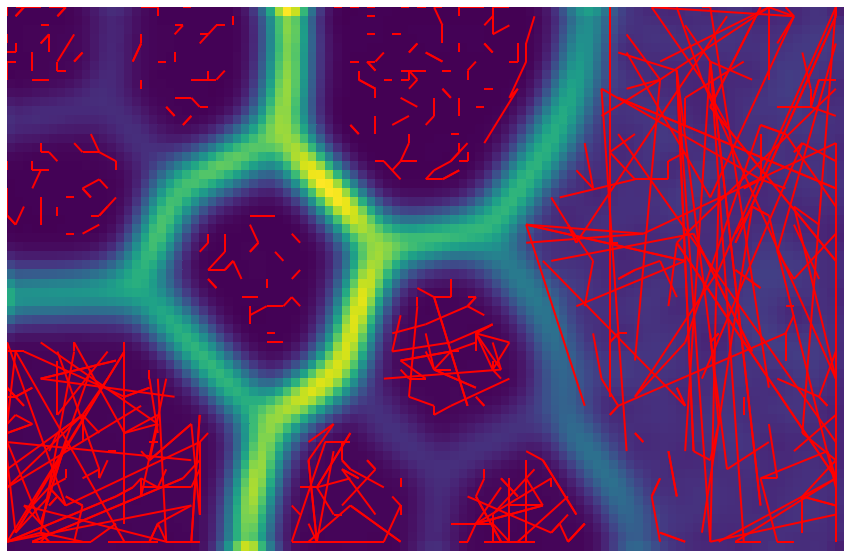

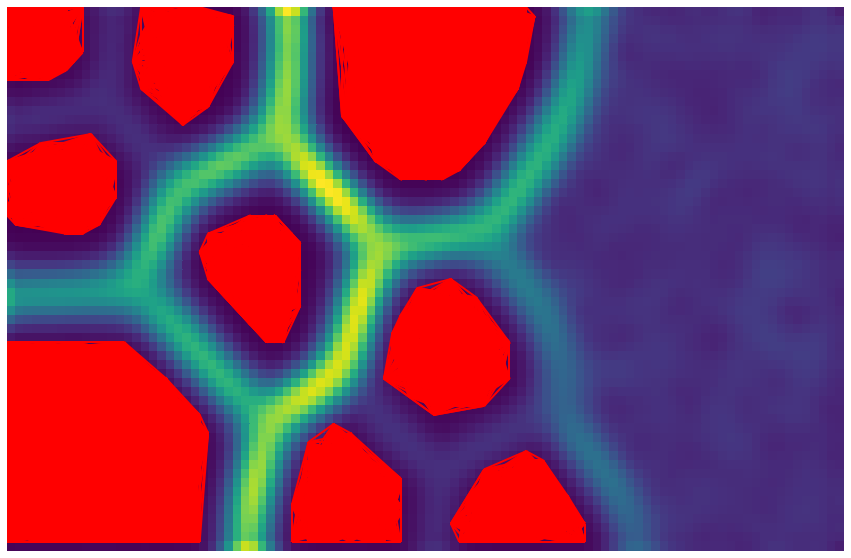

In [40]:
trainedmap = SOMToolBox_Parse('data/10clusters_input.vec')
idata, idim, idata_x, idata_y = trainedmap.read_weight_file()

smap = SOMToolBox_Parse('data/10clusters_100x60.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
fig = viz_SOMToolBox.neighbourhood_knn(k = 1, idata = idata, color='viridis', interp=False, title='U-matrix SOMToolBox')
fig.show()
fig = viz_SOMToolBox.neighbourhood_radius(radius=1, idata = idata, color='viridis', interp=False, title='U-matrix SOMToolBox 222')
fig.show()







<ipython-input-41-95649639c24d>:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-41-95649639c24d>:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-41-95649639c24d>:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


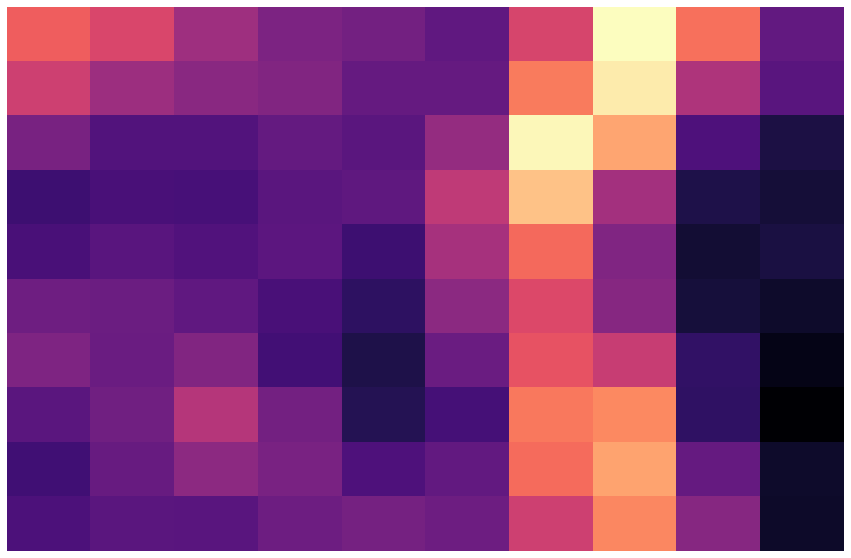

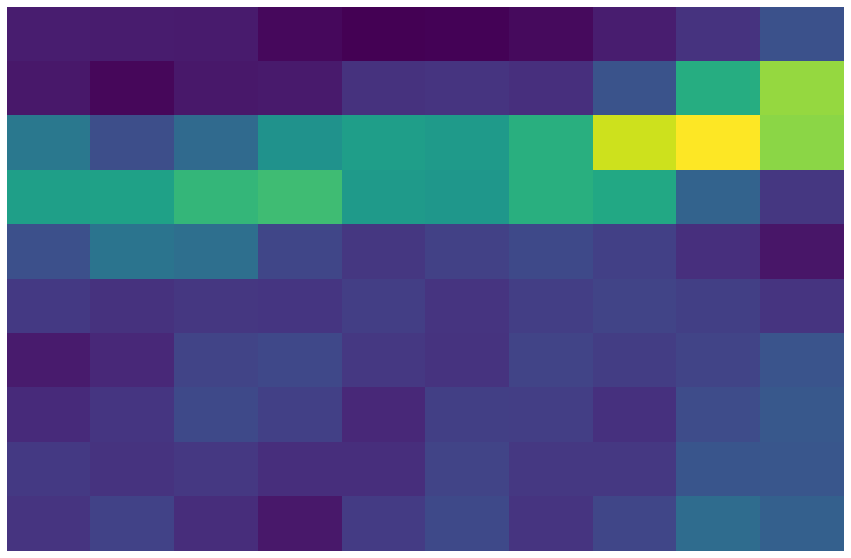

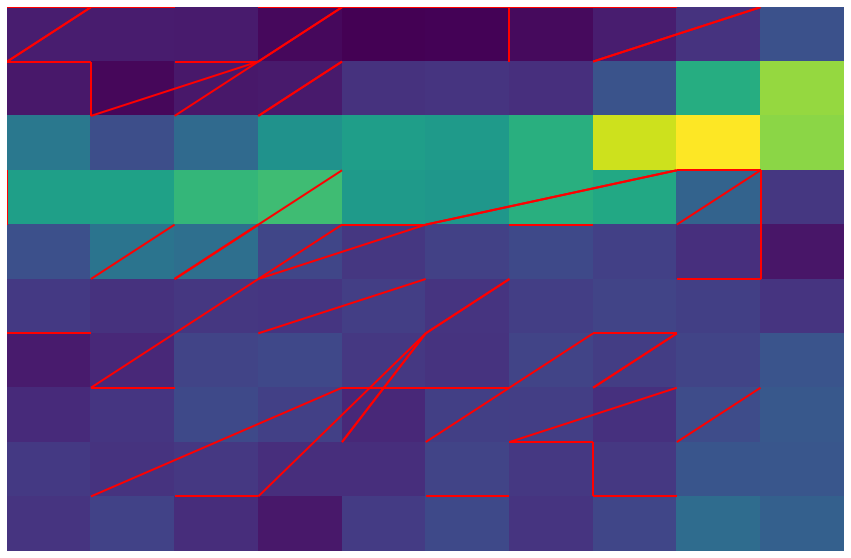

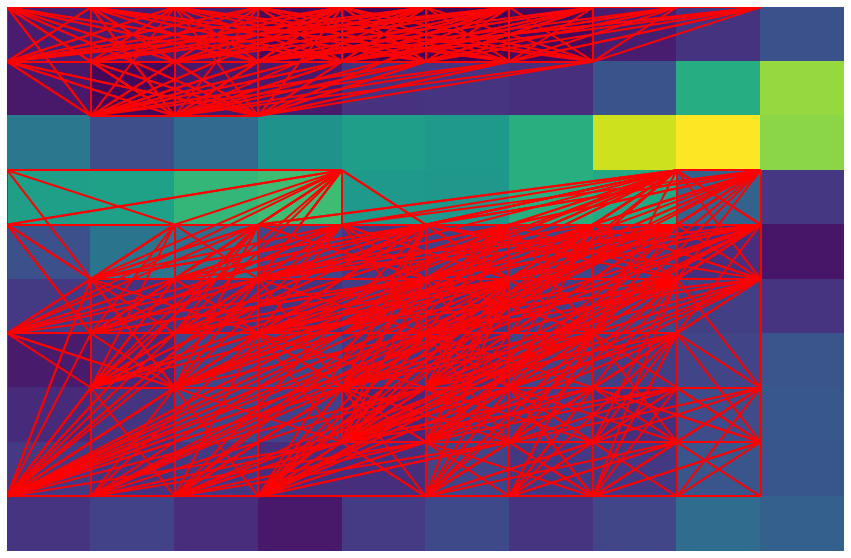

In [41]:

#interp: False, 'best', 'fast', 
#color = 'viridis': https://plotly.com/python/builtin-colorscales/



#############################
######## miniSOM ############1/0
#############################
m=10
n=10

# Pre-processing 
iris = datasets.load_iris().data
min_max_scaler = preprocessing.MinMaxScaler()
iris = min_max_scaler.fit_transform(iris)

# Train
s = som.MiniSom(m, n, iris.shape[1], sigma=0.8, learning_rate=0.7)
s.train_random(iris, 10000, verbose=False)

# Visualizaton
viz_miniSOM = SomViz(s._weights.reshape(-1,4), m, n)
um1 = viz_miniSOM.umatrix(color='magma', interp='best', title='U-matrix miniSOM')

##########################################
######## read from SOMToolBox ############
##########################################
trainedmap = SOMToolBox_Parse('iris.vec')
idata, idim, idata_x, idata_y = trainedmap.read_weight_file()

smap = SOMToolBox_Parse('iris.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
fig = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix SOMToolBox')
fig.show()

viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)

fig = viz_SOMToolBox.neighbourhood_knn(k = 1, idata = idata, color='viridis', interp=False, title='U-matrix SOMToolBox')
fig.show()

fig = viz_SOMToolBox.neighbourhood_radius(radius=1, idata = idata, color='viridis', interp=False, title='U-matrix SOMToolBox 222')
fig.show()